In [1]:
!wget https://github.com/dvlprguy/reddit-depression-analysis/raw/main/train.csv

--2020-11-25 15:48:04--  https://github.com/dvlprguy/reddit-depression-analysis/raw/main/train.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/train.csv [following]
--2020-11-25 15:48:04--  https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799996 (781K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 781.25K  --.-KB/s    in 0.06s   

2020-11-25 15:48:05 (12.2 MB/s) - ‘train.csv’ saved [799996/799996]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv("train.csv")
df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from math import pi
 
def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    """
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = [int(x) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        l = self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        return l

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)



In [5]:
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)  
plt.rc('figure', titlesize=30)  

In [2]:
%%capture
!pip install transformers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from collections import Counter,defaultdict

In [8]:
print(Counter(df['label']))

Counter({0: 5450, 1: 3050})


In [9]:
%%capture
!pip install emoji
!pip install urlextract

In [10]:
from urlextract import URLExtract
extractor = URLExtract()
import regex
import emoji
import string

In [12]:
%%capture
!apt install openjdk-8-jdk
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!pip install language-check
!pip install pycontractions

In [11]:
def modifier(tweet):
    #removing @ mentions
    tweet = tweet.lower()
    urls = extractor.find_urls(tweet)
    for url in urls:
        url = url.replace('(','\(')
        url = url.replace(')','\)')
        tweet= re.sub(url,' ',tweet) 
    txt = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', tweet, flags=re.MULTILINE)   
    txt = re.sub(r'https://','',txt)
    txt = re.sub(r'http://','',txt)
    tweet = re.sub(r'…','',txt)
    tweet = tweet.lower()
    tweet = re.sub("[^@]+@[^@]+\.[^@]+"," ",tweet) 
    tweet = re.sub("u/[A-Za-z0-9_-]+"," ",tweet)
    tweet = re.sub("/u/[A-Za-z0-9_-]+"," ",tweet)
    tweet = re.sub("r/[A-Za-z0-9_-]+"," ",tweet)
    tweet = re.sub("/r/[A-Za-z0-9_-]+"," ",tweet)
    tweet = re.sub("(@[A-Za-z0-9_-]+)"," ",tweet)
    
    return tweet
def get_emoji(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return [emoji.demojize(i)[1:-1] for  i in emoji_list]
def modify_emoji(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    for emo in set(emoji_list):
        text = re.sub('('+emo+')+',emo,text)
        st = ' '.join(emoji.demojize(emo)[1:-1].split('_'))
        res  =  st if 'skin' not in st else ' '.join(st.split()[:-3]) 
        text = re.sub(emo,' '+res+' ',text)             
    return emoji.get_emoji_regexp().sub(r'' , text)
    import string
def mod1(s):
    for c in ",.":
        s=s.replace(c," "+c+" ")
    return s.translate(str.maketrans('', '', string.punctuation))

In [13]:
text = df["text"]

In [14]:
text = [modifier(i) for i in text]

In [15]:
text = [modify_emoji(i) for i in text]

In [23]:
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

[================================================--] 96.5% 373.4/387.1MB downloaded

In [24]:
text = list(cont.expand_texts(text))

In [25]:
text = [mod1(i) for i in text]

In [26]:
def mod2(s):
    return ' '.join([i.strip() for i in s.split()])

In [27]:
text = [mod2(i) for i in text]

In [28]:
df["text"] = text

In [29]:
df["len"] = df["text"].apply( lambda x:len(x))

In [30]:
def mod3(s):
    return ' '.join([i.strip().lower() for i in s.split() if i.isalpha()])

In [31]:
df["text"] = df["text"].apply(mod3)

In [32]:
df.drop(labels=["len"],axis=1,inplace=True)

In [33]:
df.to_csv("mod_train.csv",index=False)

In [68]:
def lenspec(s):
  return len(s.split(' '))
df["len"]=df["text"].apply(lenspec)

In [69]:
complaint_len = list(df[df["label"]==1]["len"])
noncomplaint_len = list(df[df["label"]==0]["len"])

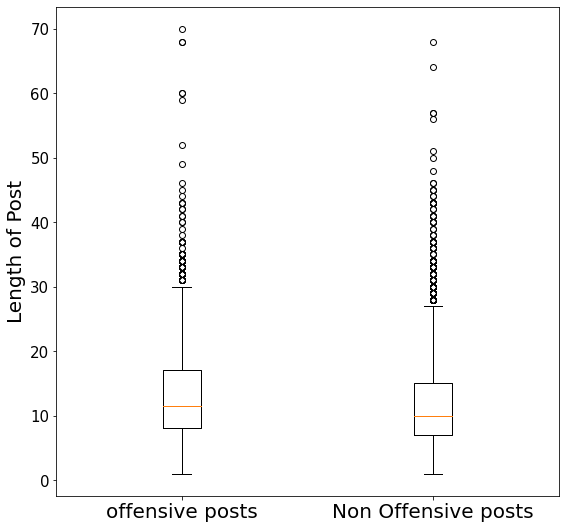

In [70]:
plt.figure(figsize=(9,9))
plt.boxplot([complaint_len,noncomplaint_len])
plt.xticks(range(1,3),labels=["offensive posts","Non Offensive posts"])
plt.ylabel("Length of Post")
plt.show()

In [71]:
df1 = df[(df.len <=50)]
df1 = df1.sample(frac=1)
df1.drop(labels=["len"],axis=1,inplace=True)
df1.to_csv("preproc_data.csv",index=False)

In [72]:
!wget https://github.com/dvlprguy/reddit-depression-analysis/raw/main/preproc_data.csv

--2020-11-25 16:47:48--  https://github.com/dvlprguy/reddit-depression-analysis/raw/main/preproc_data.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/preproc_data.csv [following]
--2020-11-25 16:47:49--  https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/preproc_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707293 (691K) [text/plain]
Saving to: ‘preproc_data.csv.1’

preproc_data.csv.1  100%[===================>] 690.72K  --.-KB/s    in 0.06s   

2020-11-25 16:47:49 (12.1 MB/s) - ‘preproc_data.csv.1’ saved [707293/707293]


In [86]:
df=pd.read_csv("preproc_data.csv")

In [87]:
df.fillna('dummy',inplace=True)

In [88]:
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
words = ' '.join(list(df["text"]))
from collections import Counter
cnt = Counter(words.split())
a=[[cnt[i],i] for i in cnt]
lis1 = sorted(a,reverse=True)[:100]
a=[[cnt[i],i] for i in cnt if i not in stop_words]
lis1 = sorted(a,reverse=True)[:100]

In [90]:
!pip install wordcloud
from wordcloud import WordCloud

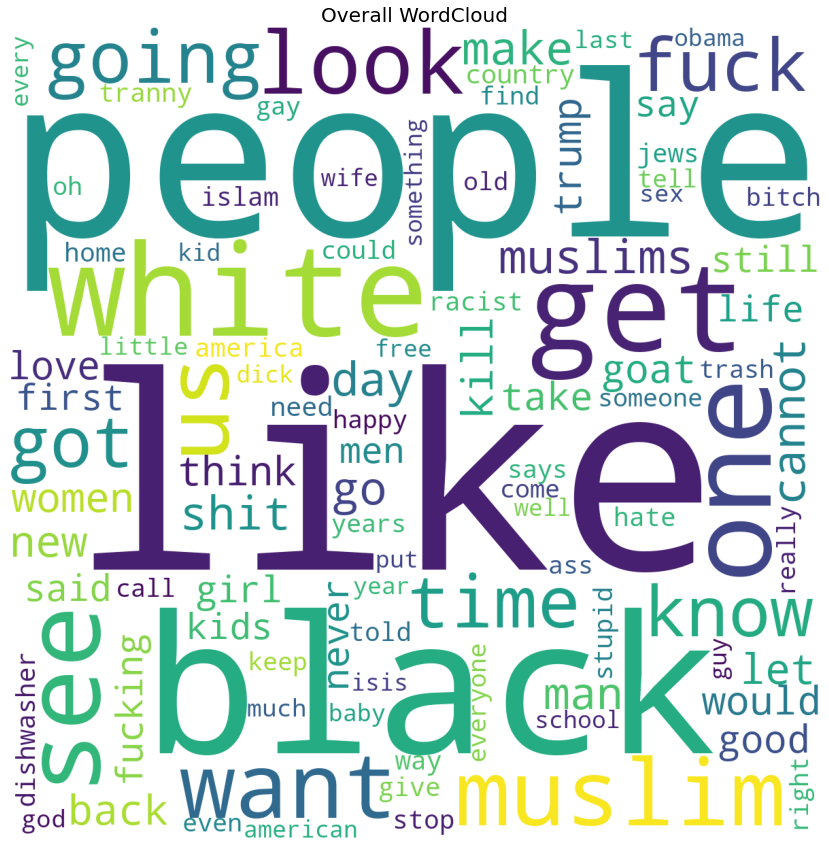

In [91]:
word_cloud_dict={j:i for i,j in lis1}
wordcloud = WordCloud(width = 1200, height = 1200,background_color ='white',min_font_size = 10).generate_from_frequencies(word_cloud_dict)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Overall WordCloud")
plt.show()

In [92]:
words = ' '.join(list(df[df["label"]==1]['text']))
from collections import Counter
cnt = Counter(words.split())
a=[[cnt[i],i] for i in cnt]
lis1 = sorted(a,reverse=True)[:100]
a=[[cnt[i],i] for i in cnt if i not in stop_words]
lis1 = sorted(a,reverse=True)[:100]

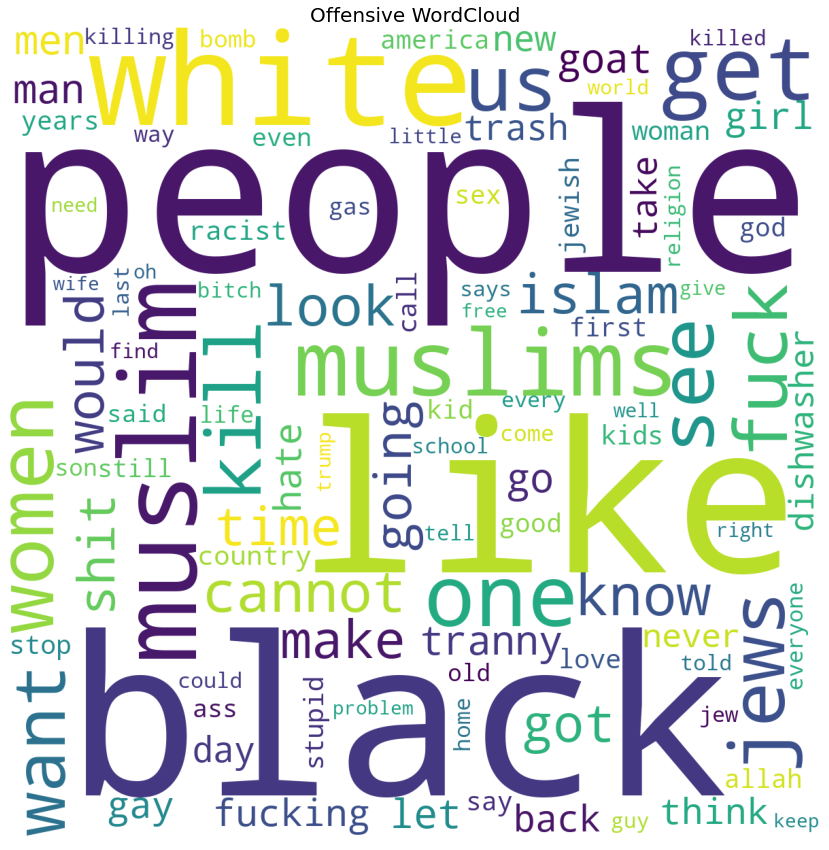

In [93]:
word_cloud_dict={j:i for i,j in lis1}
wordcloud = WordCloud(width = 1200, height = 1200,background_color ='white',min_font_size = 10).generate_from_frequencies(word_cloud_dict)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Offensive WordCloud")
plt.show()

In [94]:
words = ' '.join(list(df[df["label"]==0]['text']))
from collections import Counter
cnt = Counter(words.split())
a=[[cnt[i],i] for i in cnt]
lis1 = sorted(a,reverse=True)[:100]
a=[[cnt[i],i] for i in cnt if i not in stop_words]
lis1 = sorted(a,reverse=True)[:100]

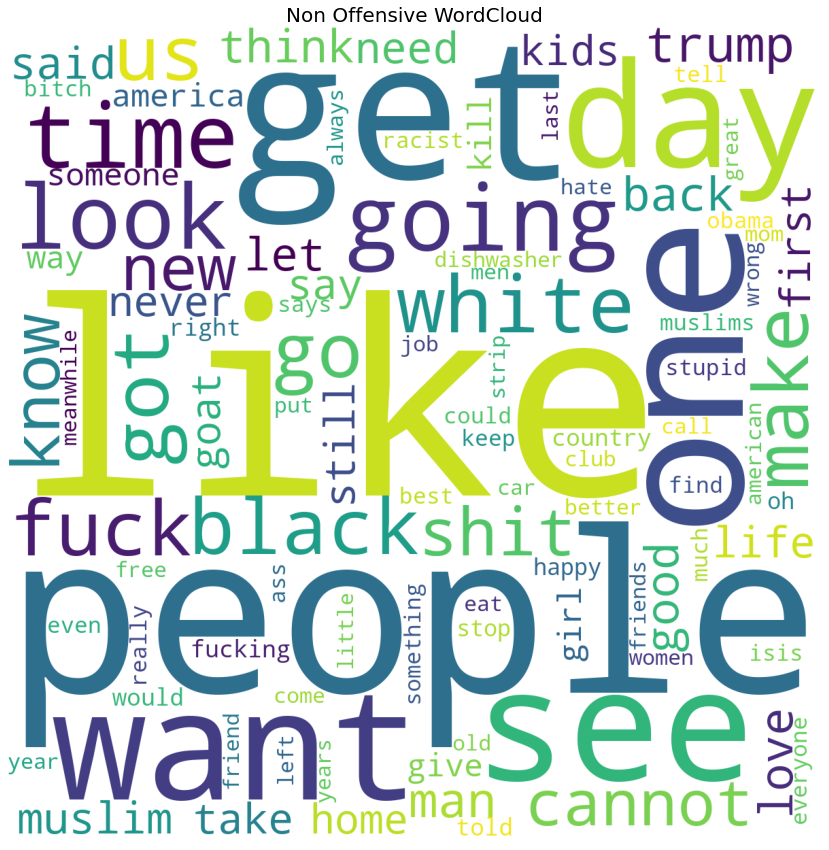

In [95]:
word_cloud_dict={j:i for i,j in lis1}
wordcloud = WordCloud(width = 1200, height = 1200,background_color ='white',min_font_size = 10).generate_from_frequencies(word_cloud_dict)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Non Offensive WordCloud")
plt.show()

In [96]:
words = ' '.join(list(df["text"]))
from collections import Counter
cnt = Counter(words.split())
a=[[cnt[i],i] for i in cnt]
lis1 = sorted(a,reverse=True)[:100]


a=[[cnt[i],i] for i in cnt ]
lis1 = sorted(a,reverse=True)[:20]
b=[[cnt[i],i] for i in cnt if i not in stop_words]
lis2 = sorted(b,reverse=True)[:20]

print(lis1)
print(lis2)

[[3220, 'you'], [3095, 'the'], [2667, 'a'], [2598, 'i'], [2332, 'to'], [1863, 'is'], [1465, 'and'], [1378, 'when'], [1358, 'not'], [1199, 'in'], [1188, 'of'], [1175, 'are'], [1125, 'it'], [1089, 'your'], [879, 'my'], [864, 'do'], [846, 'for'], [758, 'that'], [715, 'this'], [671, 'have']]
[[584, 'like'], [558, 'people'], [386, 'black'], [364, 'white'], [337, 'get'], [293, 'one'], [247, 'see'], [237, 'muslim'], [230, 'want'], [220, 'us'], [213, 'look'], [213, 'going'], [211, 'time'], [211, 'fuck'], [202, 'got'], [200, 'know'], [197, 'muslims'], [197, 'day'], [193, 'make'], [191, 'go']]


In [97]:
words = ["black","white","muslim","look","make","people","like","see","not","fuck","going","know"]

In [98]:
offense_df = df[df.label == 1]
non_offense_df = df[df.label == 0]
offense_words = ' '.join(list(offense_df["text"]))
non_offense_words = ' '.join(list(non_offense_df["text"]))

offense_cnt = Counter(offense_words.split())
non_offense_cnt = Counter(non_offense_words.split())


In [99]:
for i in words:
    print("'"+i+"':["+str(offense_cnt[i])+","+str(non_offense_cnt[i])+"],")

'black':[260,126],
'white':[231,133],
'muslim':[153,84],
'look':[79,134],
'make':[72,121],
'people':[267,291],
'like':[232,352],
'see':[94,153],
'not':[498,860],
'fuck':[88,123],
'going':[70,143],
'know':[80,120],


In [100]:
data = {'black':[260,126],
'white':[231,133],
'muslim':[153,84],
'look':[81,135],
'make':[72,124],
'people':[272,292],
'like':[235,352],
'see':[94,153],
'not':[500,862],
'fuck':[88,123],
'going':[70,143],
'know':[82,120]}

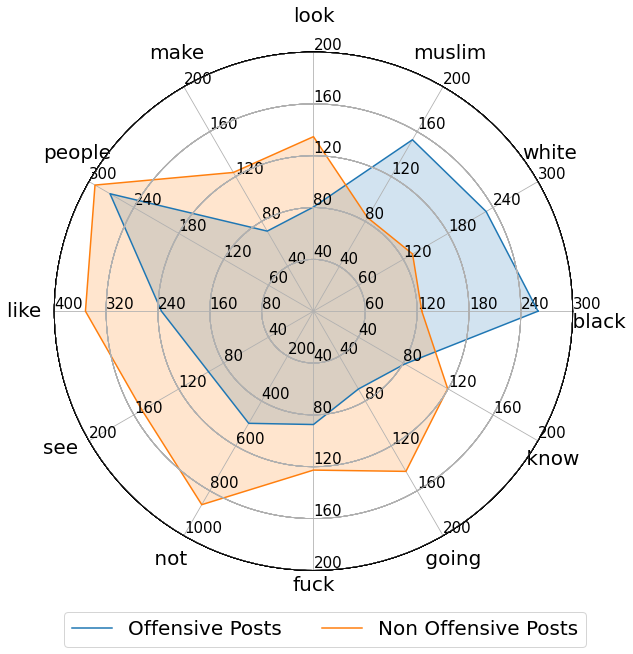

In [101]:
index = ["Offensive Posts","Non Offensive Posts"]
df2 = pd.DataFrame({
   '\n    black':[260,126],
'white\n\n':[231,133],
'muslim\n\n':[153,84],
'look\n\n':[81,135],
'make\n\n':[72,124],
'people\n\n':[272,292],
'like     ':[235,352],
'see     ':[94,153],
'\n not   ':[500,862],
'fuck':[88,123],
'\n going':[70,143],
'\n know':[82,120]
})


variables = [k[0] for k in df2.iteritems()]

ranges = [(1,300),(1,300),(1,200),(1,200),(1,200),(1,300),(1,400),(1,200),(1,1000),(1,200),(1,200),(1,200)] 
fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, variables, ranges)
lax = []
for i, name  in enumerate(index):
    data=df2.iloc[i].values
    l, = radar.plot(data, label=name)
    lax.append(l)
    radar.fill(data,alpha=0.2)

legendax = fig1.add_axes([0.8,0.8,.1,.1])
legendax.legend(handles = lax, labels=index,loc =3, bbox_to_anchor=(0.1,-0.05,0,0), bbox_transform=fig1.transFigure,ncol=3 )
legendax.axis('off')

plt.show()

In [102]:
av_len=0
for sent in df['text']:
  av_len+=len(sent.split(" "))
print(av_len/len(df['text']))

11.858135972664074


In [103]:
print(Counter(df['label']))

Counter({0: 5444, 1: 3043})


In [3]:
!wget https://github.com/dvlprguy/reddit-depression-analysis/raw/main/preproc_data.csv

--2020-11-25 17:23:38--  https://github.com/dvlprguy/reddit-depression-analysis/raw/main/preproc_data.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/preproc_data.csv [following]
--2020-11-25 17:23:38--  https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/preproc_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707293 (691K) [text/plain]
Saving to: ‘preproc_data.csv’

preproc_data.csv    100%[===================>] 690.72K  --.-KB/s    in 0.01s   

2020-11-25 17:23:38 (46.4 MB/s) - ‘preproc_data.csv’ saved [707293/707293]



In [4]:
df=pd.read_csv('preproc_data.csv')
df.head()

,id,img,label,text
0,74832,img/74832.png,0,if your man dresses like this there no doubt h...
1,51397,img/51397.png,0,when you catch your goat with another man ya d...
2,63871,img/63871.png,0,you can be any gender you want if you are ment...
3,18529,img/18529.png,1,shoot them
4,72951,img/72951.png,0,october this year i am going to get through no...


In [5]:
df.fillna('dummy text',inplace=True)

In [6]:
df.isna().any()

id       False
img      False
label    False
text     False
dtype: bool

In [7]:
print(Counter(df['label']))

Counter({0: 5444, 1: 3043})


In [8]:
source_folder = '/content'
destination_folder = '/content'

In [9]:
df_train,df_valid=train_test_split(df,test_size=0.2,random_state=42,shuffle=True,stratify=df['label'])
df_train.to_csv('ftrain.csv',index=False)
df_valid.to_csv('fvalid.csv',index=False)

In [10]:
print(Counter(df_valid['label']))
print(Counter(df_train['label']))

Counter({0: 1089, 1: 609})
Counter({0: 4355, 1: 2434})


In [11]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 5690 to 5801
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1698 non-null   int64 
 1   img     1698 non-null   object
 2   label   1698 non-null   int64 
 3   text    1698 non-null   object
dtypes: int64(2), object(2)
memory usage: 66.3+ KB


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
print(device)

cuda:0


In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_SEQ_LEN = 40
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

fields = [('id',None),('img',None),('label', label_field), ('text', text_field)]
train, valid = TabularDataset.splits(path=source_folder, train='ftrain.csv', validation='fvalid.csv',format='CSV', fields=fields, skip_header=True)
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)


In [26]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name,output_attentions=True)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [27]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [28]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        # train_correct=0
        # train_total=0
        for (labels, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output
            # train_correct+=(output==labels).sum().item()
            # train_total+=labels.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                    # valid_correct=0
                    # valid_total=0
                    # validation loop
                    for (labels,  text), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        # valid_correct+=(output==labels).sum().item()
                        valid_running_loss += loss.item()
                        # valid_total+=labels.size(0)

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                # train_acc=100*train_correct/train_total
                # valid_acc=100*valid_correct/valid_total
                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [29]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Epoch [1/10], Step [212/4250], Train Loss: 0.6136, Valid Loss: 0.5934
Model saved to ==> /content/model.pt
Model saved to ==> /content/metrics.pt
Epoch [1/10], Step [424/4250], Train Loss: 0.5833, Valid Loss: 0.6490
Epoch [2/10], Step [636/4250], Train Loss: 0.5573, Valid Loss: 0.5713
Model saved to ==> /content/model.pt
Model saved to ==> /content/metrics.pt
Epoch [2/10], Step [848/4250], Train Loss: 0.4854, Valid Loss: 0.7142
Epoch [3/10], Step [1060/4250], Train Loss: 0.5007, Valid Loss: 0.6820
Epoch [3/10], Step [1272/4250], Train Loss: 0.3988, Valid Loss: 0.8950
Epoch [4/10], Step [1484/4250], Train Loss: 0.4366, Valid Loss: 0.8072
Epoch [4/10], Step [1696/4250], Train Loss: 0.3316, Valid Loss: 0.9653
Epoch [5/10], Step [1908/4250], Train Loss: 0.3798, Valid Loss: 0.8040
Epoch [5/10], Step [2120/4250], Train Loss: 0.2962, Valid Loss: 1.0510
Epoch [6/10], Step [2332/4250], Train Loss: 0.3352, Valid Loss: 0.8704
Epoch [6/10], Step [2544/4250], Train Loss: 0.2609, Valid Loss: 1.1039


Model loaded from <== /content/metrics.pt


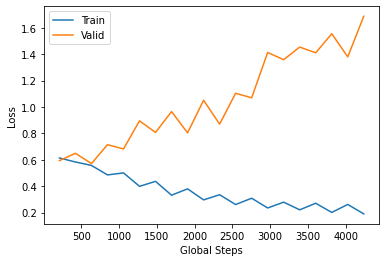

In [30]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /content/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6250    0.4762    0.5405       609
           0     0.7415    0.8402    0.7878      1089

    accuracy                         0.7097      1698
   macro avg     0.6832    0.6582    0.6642      1698
weighted avg     0.6997    0.7097    0.6991      1698



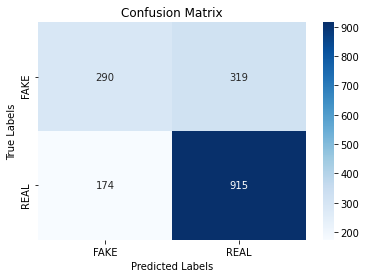

In [31]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, text), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, valid_iter )